In this notebook we look for interactions between the odor and the v_fwd representations in G4S.

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test, calc_r2
from plot import set_font_size, unity_line

import CONFIG as C

Parameters

In [2]:
TRAIN_LEN = 32  # s
TEST_LEN = 8  # s

EXPTS = ['white_odor_fluct']
TARG = 'g4s'

WDW = (-3, 1)

METHOD = 'built-in'
PARAMS = {'model': LinearRegression}

Resuable subroutines

Linear models

In [3]:
class ModelO(object):
    
    name = 'O'
    
    def __init__(self, trial):
        
        # run odor_binary --> TARG fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name=TARG,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)

In [4]:
class ModelVF(object):
    
    name = 'VF'
    
    def __init__(self, trial):
        
        # run v_fwd --> TARG fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['v_fwd'],
            y_name=TARG,
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)

In [5]:
class ModelOVFI(object):
    
    name = 'OVFI'
    
    def __init__(self, trial):
        
        # run odor_binary --> TARG fit
        self.o = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name=TARG,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)
        
        # run v_fwd --> TARG fit
        self.vf = fit_h_train_test(
            trial=trial,
            x_names=['v_fwd'],
            y_name=TARG,
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)
        
        self.trial_name = trial.name
        self.y_name = TARG
        
        self.train = self.o.train & self.vf.train
        self.test = self.o.test & self.vf.test
        self.t = self.o.t
        
        self.y = self.o.y
        
        self.y_hat_train = self.o.y_hat_train + self.vf.y_hat_train
        self.y_hat_test = self.o.y_hat_test + self.vf.y_hat_test
        
        self.r2_train = calc_r2(self.y, self.y_hat_train)
        self.r2_test = calc_r2(self.y, self.y_hat_test)

In [6]:
class ModelOVFJ(object):
    
    name = 'OVFJ'
    
    def __init__(self, trial):
        
        # run joint (odor_binary, v_fwd) --> TARG fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary', 'v_fwd'],
            y_name=TARG,
            wdws={'odor_binary': WDW, 'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS,
            normed=True,
            C=C)

### Plot true vs predicted G4S for each trial/model

In [7]:
# load trials
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

In [8]:
# fit models
models = {}

for model_class in [ModelO, ModelVF, ModelOVFI, ModelOVFJ]:
    
    models_ = {trial.name: model_class(trial) for trial in trials}
    models[model_class.name] = models_

In [9]:
AX_GRID = (len(trials), len(models))
AX_H = 3.5
FIG_SIZE = (16, AX_H*AX_GRID[0])

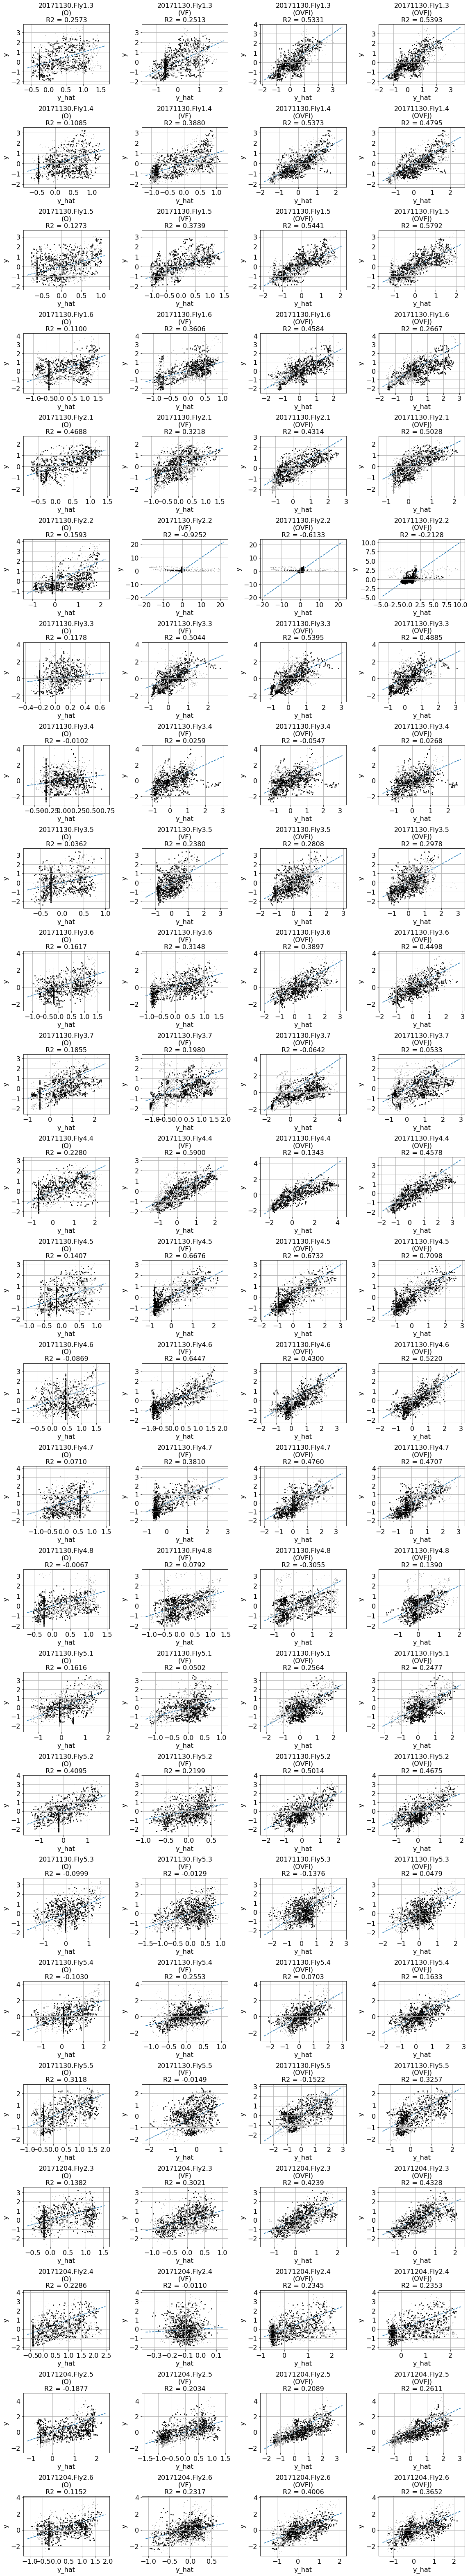

In [10]:
fig, axs = plt.subplots(*AX_GRID, figsize=FIG_SIZE, tight_layout=True)

for trial, ax_row in zip(trials, axs):
    for model_class, ax in zip([ModelO, ModelVF, ModelOVFI, ModelOVFJ], ax_row):
        
        model = models[model_class.name][trial.name]
        
        if model.name != 'OVFI':
            
            y = model.rslt.y
            y_hat_train = model.rslt.y_hat_train
            y_hat_test = model.rslt.y_hat_test
            r2_test = model.rslt.r2_test
            
        elif model.name == 'OVFI':
            
            y = model.y
            y_hat_train = model.y_hat_train
            y_hat_test = model.y_hat_test
            r2_test = model.r2_test
            
        ax.scatter(y_hat_train, y, lw=0, c='gray', s=1)
        ax.scatter(y_hat_test, y, lw=0, c='k', s=8)
        
        unity_line(ax, *ax.get_xlim(), ls='--', zorder=-1)
        
        ax.grid()

        ax.set_title('{0}\n({1})\nR2 = {2:.4f}'.format(trial.name, model.name, r2_test))
            
for ax in axs.flatten():
    ax.set_xlabel('y_hat')
    ax.set_ylabel('y')
    set_font_size(ax, 16)

### Make bar plot of R2 values

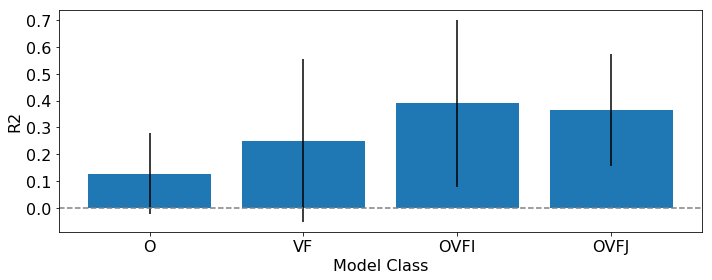

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

r2_mdns = []
r2_stds = []

for model_class in [ModelO, ModelVF, ModelOVFI, ModelOVFJ]:
    
    r2s = []
    
    for trial in trials:
        model = models[model_class.name][trial.name]
        
        if model.name != 'OVFI':
            r2 = model.rslt.r2_test
        elif model.name == 'OVFI':
            r2 = model.r2_test
            
        r2s.append(r2)
        
    r2_mdns.append(np.nanmedian(r2s))
    r2_stds.append(np.nanstd(r2s))
    
x_bar = np.arange(len(r2_mdns))
x_ticks = x_bar
x_tick_labels = [model_class.name for model_class in [ModelO, ModelVF, ModelOVFI, ModelOVFJ]]

ax.bar(x_bar, r2_mdns, yerr=r2_stds, align='center')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

ax.axhline(0, color='gray', ls='--')

ax.set_xlabel('Model Class')
ax.set_ylabel('R2')

set_font_size(ax, 16)

### Show filters

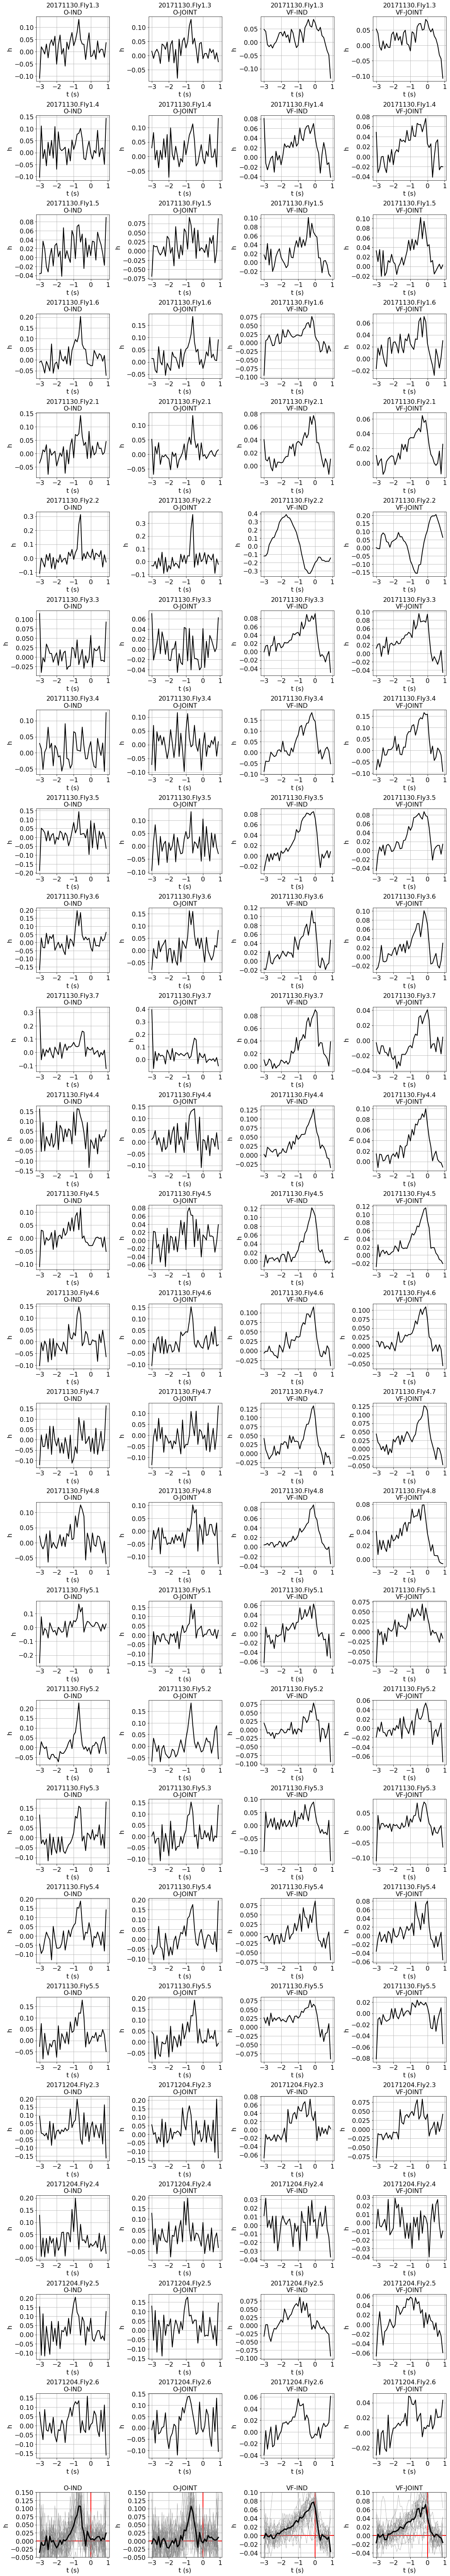

In [12]:
AX_GRID = (len(trials) + 1, len(models))
AX_H = 3.5
FIG_SIZE = (16, AX_H*AX_GRID[0])

fig, axs = plt.subplots(*AX_GRID, figsize=FIG_SIZE, tight_layout=True)

labels = ['O-IND', 'O-JOINT', 'VF-IND', 'VF-JOINT']

t_hs = {label: [] for label in labels}
hs = {label: [] for label in labels}

y_lims = {
    'O-IND': (-0.05, .15), 'O-JOINT': (-0.05, .15),
    'VF-IND': (-0.05, 0.1), 'VF-JOINT': (-0.05, 0.1),
}

# plot individual trial filters
for trial, ax_row in zip(trials, axs):
    for ctr, ax in enumerate(ax_row):
        
        if ctr == 0:
            # O independent
            
            model = models['O'][trial.name]
            t_h = model.rslt.t_hs['odor_binary']
            h = model.rslt.hs['odor_binary']
            
            label = 'O-IND'

        elif ctr == 1:
            # O joint
            
            model = models['OVFJ'][trial.name]
            t_h = model.rslt.t_hs['odor_binary']
            h = model.rslt.hs['odor_binary']
            
            label = 'O-JOINT'
            
        elif ctr == 2:
            # VF independent
            
            model = models['VF'][trial.name]
            t_h = model.rslt.t_hs['v_fwd']
            h = model.rslt.hs['v_fwd']
            
            label = 'VF-IND'
            
        elif ctr == 3:
            # VF joint
            
            model = models['OVFJ'][trial.name]
            t_h = model.rslt.t_hs['v_fwd']
            h = model.rslt.hs['v_fwd']
            
            label = 'VF-JOINT'
            
        ax.plot(t_h, h, lw=2, c='k')
        ax.set_title('{}\n{}'.format(trial.name, label))
        
        t_hs[label].append(t_h)
        hs[label].append(h)

# plot mean filters
t_hs_mean = {label: np.nanmedian(t_hs[label], 0) for label in labels}
hs_mean = {label: np.nanmedian(hs[label], 0) for label in labels}

for label, ax in zip(labels, axs[-1, :]):
    
    ax.axhline(0, c='r', lw=2)
    ax.axvline(0, c='r', lw=2)
    
    ax.plot(t_hs_mean[label], np.array(hs[label]).T, lw=0.5, color='gray')
    ax.plot(t_hs_mean[label], hs_mean[label], lw=3, color='k')

    ax.set_ylim(y_lims[label])
    
    ax.set_title(label)
    
        
for ax in axs.flatten():
    
    ax.grid()
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('h')
    
    set_font_size(ax, 16)